In [68]:
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import matplotlib.pyplot as plt
from keras import layers

In [69]:
dataset = keras.preprocessing.image_dataset_from_directory(directory="PlantVillage", shuffle=True, seed=42,image_size=(256,256),batch_size=32)

Found 16011 files belonging to 10 classes.


In [70]:
class_name = dataset.class_names

In [71]:
for image,label in dataset.take(1):
    print(image.shape)
    print(label.numpy())

(32, 256, 256, 3)
[2 7 7 9 5 3 4 8 2 9 0 7 7 2 0 7 0 6 0 2 6 7 9 7 1 5 9 6 1 7 6 6]


Visualise the images

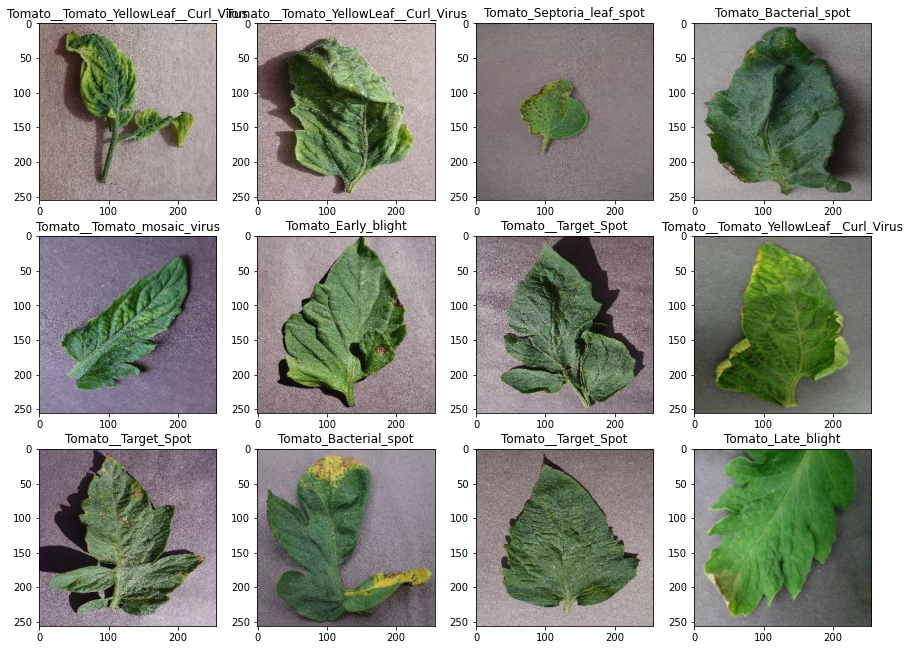

In [72]:
plt.figure(figsize=(15,15))
for image,label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])
        

        

Split the dataset

In [73]:
def train_test_split(dataset, train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size,seed=123)
    
    dataset_size = len(dataset)
    
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    
    return train_dataset,val_dataset,test_dataset
    
    

In [74]:
train_ds,validation_ds,test_ds = train_test_split(dataset=dataset)

In [75]:
for image,label in train_ds.take(1):
    print(image.shape)
    print(label.numpy())

(32, 256, 256, 3)
[8 7 7 0 9 5 0 6 7 4 0 0 2 1 1 6 1 0 3 5 6 2 7 4 7 5 6 4 9 2 2 6]


In [76]:
len(train_ds),len(validation_ds),len(test_ds),len(dataset)

(400, 50, 51, 501)

Cache, shuffle, prefetch

In [77]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Data Preprocessing(Keras layers)

In [78]:

preprocessing = keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(100,100),
    keras.layers.experimental.preprocessing.Rescaling(1./255)
])

Data Augmentation layers

In [79]:
augment = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.3),
    
])

Apply DataAugmentation to training dataset

In [80]:
# train_ds = train_ds.map(
#     lambda x, y: (augment(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architecture

In [81]:
input_shape = (32,100,100,3)

model = keras.Sequential([
    preprocessing,
    keras.layers.InputLayer(input_shape=input_shape), #(batch_size, image_size,image_size,channels)
    keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128,kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128,kernel_size=(3,3),activation="relu"),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, activation="relu", kernel_size=(3,3)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128,activation="relu"),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dense(10,activation="softmax")
    
])
model.build(input_shape=input_shape)

In [82]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [83]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=validation_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


2022-01-23 19:14:33.425862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - ETA: 0s - loss: 1.6850 - accuracy: 0.3895

2022-01-23 19:15:50.514667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - 88s 201ms/step - loss: 1.6850 - accuracy: 0.3895 - val_loss: 1.0384 - val_accuracy: 0.6319
Epoch 2/50
400/400 [==============================] - 75s 186ms/step - loss: 0.8987 - accuracy: 0.6902 - val_loss: 0.8281 - val_accuracy: 0.7462
Epoch 3/50
400/400 [==============================] - 70s 176ms/step - loss: 0.5412 - accuracy: 0.8138 - val_loss: 0.4771 - val_accuracy: 0.8325
Epoch 4/50
400/400 [==============================] - 70s 176ms/step - loss: 0.4201 - accuracy: 0.8570 - val_loss: 0.5822 - val_accuracy: 0.8056
Epoch 5/50
400/400 [==============================] - 73s 183ms/step - loss: 0.3316 - accuracy: 0.8849 - val_loss: 0.2885 - val_accuracy: 0.9094
Epoch 6/50
400/400 [==============================] - 74s 184ms/step - loss: 0.2655 - accuracy: 0.9097 - val_loss: 0.2624 - val_accuracy: 0.9044
Epoch 7/50
400/400 [==============================] - 77s 193ms/step - loss: 0.2527 - accuracy: 0.9154 - val_loss: 0.3383 - val_accuracy: 0.8

In [84]:
model.evaluate(test_ds)

51/51 [==============================] - 14s 111ms/step - loss: 0.0855 - accuracy: 0.9816


[0.08547869324684143, 0.9816176891326904]

In [85]:
def predict(model, img):
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    
    prediction = model.predict(img_array)
    
    confidence = round(100*np.max(prediction[0]),2)
    prediction_class = class_name[np.argmax(prediction[0])]
    
    return confidence, prediction_class

2022-01-23 20:23:47.099469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


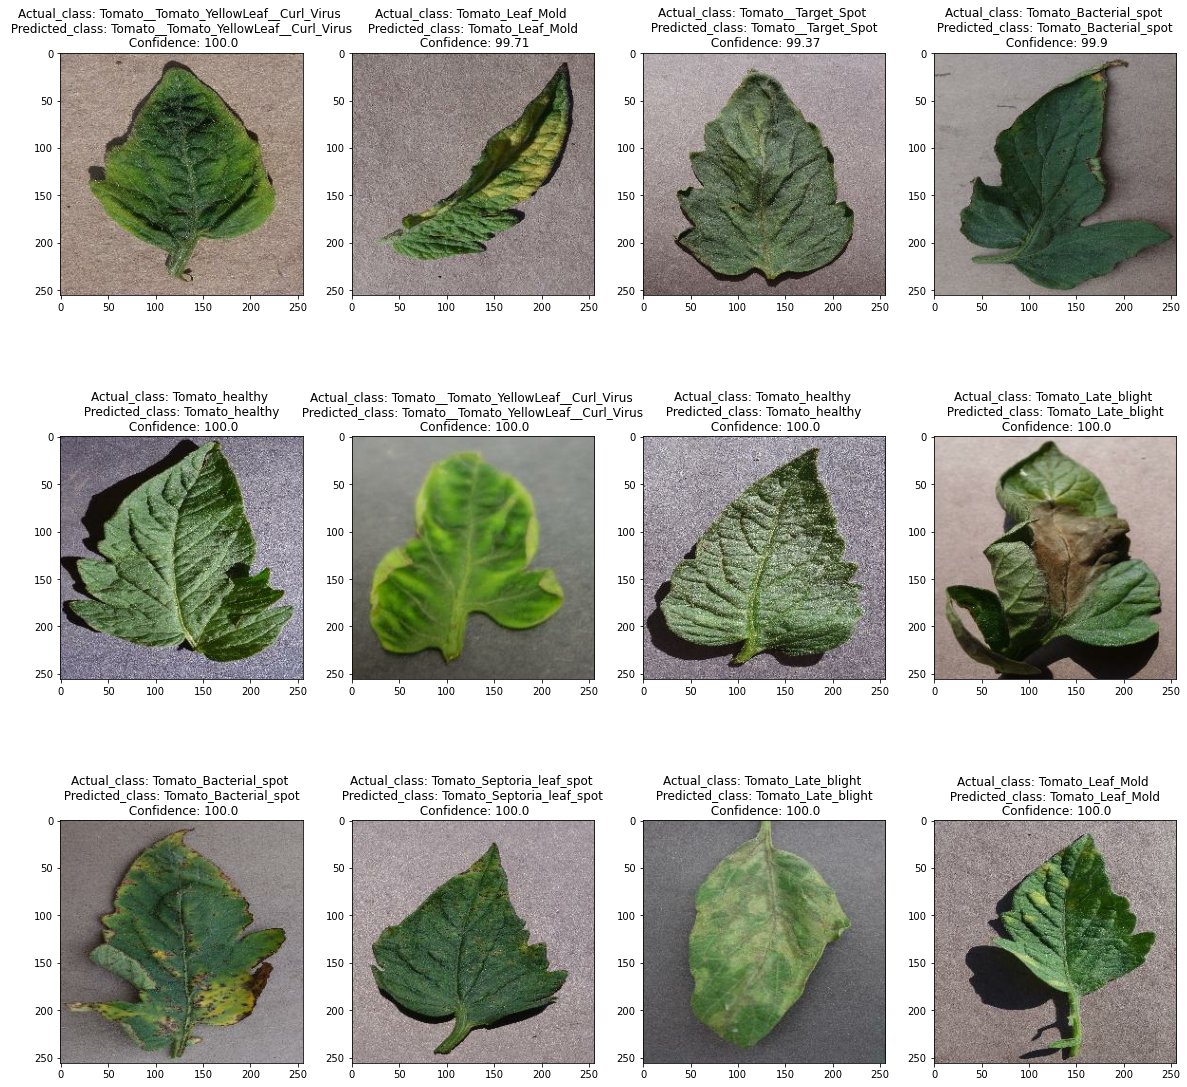

In [86]:
plt.figure(figsize=(20,20))
for images, labels in test_ds.take(1):
    for i in range(12):
        axis = plt.subplot(3,4,i+1)
        confidence, prediction_class = predict(model,images[i].numpy())
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Actual_class: {class_name[labels[i]]} \n Predicted_class: {prediction_class} \n Confidence: {confidence}')
    

Saving the model

In [48]:
import os
model_version = max([int(i) for i in os.listdir("./models/")]) +1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/3/assets
